<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/FastAiPyTorchULMFiTTextClassifierWhoseLine_wStopWordsRemoval_20200701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
#!pip install fastai

In [43]:
# import libraries
import codecs, os, numpy as np, pandas as pd
pd.set_option('display.max_colwidth', None) #to prevent cell display truncation

import re#for text preprocessing (checking for non words)

#metrics calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

#fastai
import fastai
from fastai import *
from fastai.text import * 
from functools import partial

#stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
temp = open("/content/gdrive/My Drive/Colab_Notebooks_Bala/WhoseLineIsItAnywayTRAIN.csv", 'r', encoding='latin-1')
WhoseLineData = pd.read_csv(temp)
print('File shape', WhoseLineData.shape, '\n')
print(WhoseLineData.columns, '\n')

File shape (18977, 2) 

Index(['text', 'author'], dtype='object') 



In [46]:
#Ran out of RAM for predictions. Hence dropping out records from some of the more frequent classes. 
WhoseLineData.author.value_counts()

0    3859
5    3517
4    3184
2    2621
3    1314
9    1142
7    1054
8     910
6     755
1     621
Name: author, dtype: int64

In [47]:
df_low=WhoseLineData[WhoseLineData.author.isin([1,6,8,7,9,3])]
df_high=WhoseLineData[~WhoseLineData.author.isin([1,6,8,7,9,3])]
g = df_high.groupby('author')
df_high_trimmed = pd.DataFrame(g.apply(lambda x: x.sample(2000)))
df = pd.concat([df_low,df_high_trimmed])
df = df.reset_index(drop=True)
df = pd.DataFrame({'label':df.author, 'text':df.text})
df.label.value_counts()

5    2000
4    2000
2    2000
0    2000
3    1314
9    1142
7    1054
8     910
6     755
1     621
Name: label, dtype: int64

In [48]:
#Data Preprocessing
#knock out the many white spaces & non words 
df['text'].replace(r'\s+', ' ', regex=True, inplace=True)
df['text'] = df['text'].str.lower().str.replace("[^a-zA-Z]", " ")

#unique word count
uniqueWords = set()
df['text'].str.split().apply(uniqueWords.update)
print('# of unique words',len(uniqueWords))
print('Sample of unique words',list(uniqueWords)[1070:1100])

#number of authors/ classes for the classifier
print("Authors in dataset", sorted(df['label'].unique()))

#to get an idea for the typical length of each text
df['textLength'] = df['text'].str.split().str.len()

#size of writings/ document
display(df.describe())

# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['text'] = detokenized_doc

# of unique words 59693
Sample of unique words ['abstaining', 'gostiny', 'unsuspecting', 'caused', 'contempt', 'lordliness', 'wafted', 'hypochondria', 'humbler', 'obduracy', 'polluting', 'owning', 'incentive', 'foretopsail', 'twining', 'british', 'rover', 'she', 'cockatoo', 'droshky', 'sparest', 'prematurely', 'fares', 'bacteriologics', 'davy', 'replying', 'wellnigh', 'wore', 'macher', 'porti']
Authors in dataset [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,label,textLength
count,13796.000000,13796.000000
mean,4.061250,417.211656
std,2.751878,323.539236
min,0.000000,23.000000
25%,2.000000,258.000000
50%,4.000000,354.000000
75%,6.000000,489.000000
max,9.000000,5908.000000


In [49]:
# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 35)
df_trn.shape, df_val.shape

((11726, 3), (2070, 3))

In [50]:
#data preparation for the language and classifier models

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [51]:
#language model fine tuning on data from the target task, on which classification is to be performed
#note that word distribution probability will be different between the wiki corpus and the target domain 
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


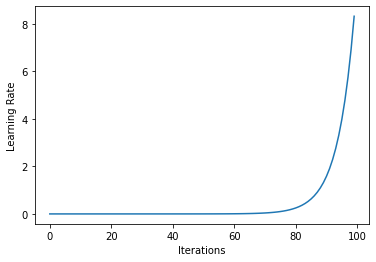

In [53]:
learn.recorder.plot_lr()

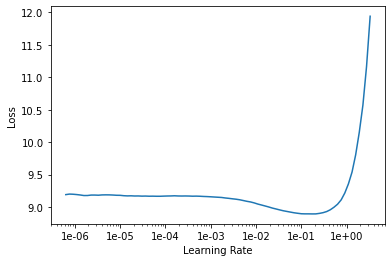

In [54]:
learn.recorder.plot()

In [55]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)#initial short increase in the learning rate to help the model to quickly converge 
#to a suitable region of the parameter space for the target task, followed by a long decay period which allows 
#for the further refining of the parameters

epoch,train_loss,valid_loss,accuracy,time
0,7.706026,7.455393,0.045052,02:54


In [56]:
learn.save_encoder('ft_enc_whoseLine_small')

In [57]:
#classifier training, using the fine tuned language model from above
#LSTM architecture selected. Transformers are also available in FastAi
#drop_mult controls layers wise drop outs. Setting =1 leaves them at their defaults
learn = text_classifier_learner(data_clas, drop_mult=0.7, arch=AWD_LSTM)
#learn.load_encoder('ft_enc_whoseLine_small')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11726 items)
x: TextList
xxbos leopard giant form towering others caused sudden hush fall assemblage brothers said deep voice stranger come among us beast curious form great magician able change shapes men beasts stranger come us another kind sky warn us danger threatens us offer us way escape danger says friend proved counselors magic powers listen say message brought sky let speak came great roar great company assembled beasts ruggedo nome sprang upon flat rock beside gugu king another roar gentle time showed astonished beasts sight curious form lion face surrounded mane pure white hair eagle wings attached shoulders monkey body long nearly touched ground powerful arms legs addition wings end long strong tail golden ball never beast beheld curious creature sight stranger said great magician filled present awe wonder kiki stayed half hidden shelf rock scarcely noticed boy realized old nome helpless without magic power also realized

In [58]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.987413,0.658253,0.786473,01:05


In [59]:
learn.save_encoder('txt_classifier_whoseLine_small')

In [60]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,257,0,14,1,34,33,0,9,6,7
1,0,70,0,0,1,0,1,11,0,1
2,0,0,238,1,2,29,0,2,7,3
3,0,0,1,184,2,5,0,0,0,2
4,20,0,4,1,244,10,0,3,0,9
5,2,4,19,3,3,179,0,4,7,11
6,8,2,1,0,2,0,107,9,1,16
7,4,17,1,0,6,8,3,114,0,4
8,0,0,21,0,0,15,0,1,116,0


In [61]:
precision, recall, fscore, support = score(targets, predictions, labels = [0,1,2,3,4,5,6,7,8,9])
results1 = pd.concat((pd.Series([0,1,2,3,4,5,6,7,8,9]), pd.Series(precision), pd.Series(recall), pd.Series(fscore), pd.Series(support)), axis=1, join = 'outer')
results1.columns=('label','precision', 'recall', 'fscore', 'support')
print('Results','\n','*'*50,'\n',round(results1,2))

Results 
 ************************************************** 
    label  precision  recall  fscore  support
0      0       0.71    0.86    0.78      300
1      1       0.83    0.75    0.79       93
2      2       0.84    0.79    0.82      300
3      3       0.95    0.93    0.94      197
4      4       0.84    0.81    0.83      300
5      5       0.77    0.60    0.67      300
6      6       0.73    0.95    0.83      113
7      7       0.73    0.72    0.72      158
8      8       0.76    0.85    0.80      137
9      9       0.70    0.69    0.70      172
